In [ ]:
import math
import os

import jax
import jax.numpy as jnp
import numpy as np
import soundfile as sf
from scipy.signal import resample_poly

from iklp.hyperparams import Hyperparams
from iklp.periodic import periodic_kernel_phi
from iklp.state import compute_expectations, init_state
from iklp.vi import compute_elbo_bound, update_delta_a, vi_step
from utils import top_p_indices

In [ ]:
seed = 0
wav_file = (
    os.environ["PROJECT_DATA_PATH"]
    + "/OPENGLOT/RepositoryI/Vowel_AE/AE_whispery_280Hz.wav"
)

In [4]:
P = 9
HOP = 160  # shift between successive windows

TARGET_SR = 8000  # adjust together with FRAME_LEN
FRAME_LEN = 1024

NOISE_FLOOR_DB = -60.0  # for psd_svd
MAX_ITER = 1000

In [5]:
def _mono(x: np.ndarray) -> np.ndarray:
    """Return mono signal (pick channel 0 if multichannel)."""
    return x[:, 0] if x.ndim > 1 else x


def _resample(x: np.ndarray, sr_in: int, sr_out: int) -> np.ndarray:
    """Band-limited polyphase resampling that preserves dtype."""
    if sr_in == sr_out:
        return x
    g = math.gcd(sr_out, sr_in)
    up = sr_out // g
    down = sr_in // g
    return resample_poly(x, up, down, axis=0).astype(x.dtype)


def _frame_signal(x: np.ndarray) -> np.ndarray:
    """Return a view of `x` with shape (n_frames, FRAME_LEN)."""
    if len(x) < FRAME_LEN:
        return np.empty((0, FRAME_LEN), x.dtype)
    n_frames = 1 + (len(x) - FRAME_LEN) // HOP
    return np.lib.stride_tricks.as_strided(
        x,
        shape=(n_frames, FRAME_LEN),
        strides=(HOP * x.strides[0], x.strides[0]),
        writeable=False,
    )

In [6]:
f0, Phi = periodic_kernel_phi(
    I=400, M=FRAME_LEN, fs=TARGET_SR, noise_floor_db=NOISE_FLOOR_DB
)

h = Hyperparams(Phi, P=P)

update_delta_a = jax.jit(update_delta_a)
vi_step = jax.jit(vi_step)
compute_elbo_bound = jax.jit(compute_elbo_bound)
compute_expectations = jax.jit(compute_expectations)

In [7]:
def process_frame(key, frame, h):
    # Test (first run very slow, then fast)
    state = init_state(key, frame, h)

    # Updating q(a) = delta(a* - a) as the very first update
    # is known to yield better convergence
    # as it is initalized to zeroes
    state = update_delta_a(state)
    # TODO shift order of updates by -1 such that update_delta_a is first

    score = -jnp.inf
    criterion = 0.0001

    for i in range(MAX_ITER):
        E = compute_expectations(state)
        print("Top 5 frequencies:")
        print([f.item() for f in f0[top_p_indices(E.theta)[:5]]])

        state = vi_step(state)

        lastscore = score
        score = compute_elbo_bound(state)

        if i == 0:
            improvement = 1.0
        else:
            improvement = (score - lastscore) / jnp.abs(lastscore)

        print(
            "iteration {}: bound = {:.2f} ({:+.5f} improvement)".format(
                i, score, improvement
            )
        )
        if improvement < 0.0:
            print("Diverged")
            break
        if improvement < criterion:
            print("Converged")
            break
        if jnp.isnan(improvement) and i > 0:
            print("NaN")
            break

    return (state, score)

In [8]:
audio, sr_in = sf.read(wav_file, always_2d=False, dtype="float64")
audio = _mono(audio)
audio = _resample(audio, sr_in, TARGET_SR)

# Normalize to unit power
audio = audio / np.sqrt(np.mean(audio**2))

print(f"→ Loaded {wav_file} ({len(audio)} samples, {sr_in} Hz)")

frames = _frame_signal(audio)
results = []

master_key = jax.random.PRNGKey(seed)
keys = jax.random.split(master_key, len(frames))

for key, frame in zip(keys, frames):
    print(f"→ → Processing frame {len(results) + 1}/{len(frames)}")
    # Add to the results also information about which frame was processed
    result = {
        "frame_index": len(results),
        "frame": frame,
    }
    result["state"], result["score"] = process_frame(key, frame, h)
    results.append(result)

→ Loaded /home/marnix/thesis/data/OPENGLOT/RepositoryI/Vowel_AE/AE_whispery_280Hz.wav (1600 samples, 8000 Hz)


→ → Processing frame 1/4


Top 5 frequencies:


[333.8843265536997, 168.39854803349746, 394.47937568118846, 181.1447328527803, 329.2762017215981]


iteration 0: bound = -1632.05 (+1.00000 improvement)
Top 5 frequencies:
[274.85040715494364, 275.8070143107821, 276.7669509041138, 273.8971178888002, 277.7302285229285]


iteration 1: bound = -1190.40 (+0.27061 improvement)
Top 5 frequencies:
[275.8070143107821, 274.85040715494364, 276.7669509041138, 273.8971178888002, 277.7302285229285]


iteration 2: bound = -848.77 (+0.28698 improvement)
Top 5 frequencies:
[275.8070143107821, 274.85040715494364, 276.7669509041138, 273.8971178888002, 277.7302285229285]


iteration 3: bound = -506.61 (+0.40313 improvement)
Top 5 frequencies:
[275.8070143107821, 276.7669509041138, 274.85040715494364, 277.7302285229285, 273.8971178888002]


iteration 4: bound = -79.03 (+0.84400 improvement)
Top 5 frequencies:
[275.8070143107821, 276.7669509041138, 274.85040715494364, 277.7302285229285, 273.8971178888002]


iteration 5: bound = 288.54 (+4.65093 improvement)
Top 5 frequencies:


[275.8070143107821, 276.7669509041138, 274.85040715494364]


iteration 6: bound = 647.62 (+1.24446 improvement)
Top 5 frequencies:
[275.8070143107821, 276.7669509041138, 274.85040715494364]


iteration 7: bound = 782.04 (+0.20755 improvement)
Top 5 frequencies:


[275.8070143107821, 276.7669509041138]


iteration 8: bound = 822.28 (+0.05146 improvement)
Top 5 frequencies:
[275.8070143107821, 276.7669509041138]


iteration 9: bound = 836.50 (+0.01729 improvement)
Top 5 frequencies:


[275.8070143107821]


iteration 10: bound = 844.76 (+0.00987 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 11: bound = 850.16 (+0.00640 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 12: bound = 854.00 (+0.00451 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 13: bound = 856.85 (+0.00334 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 14: bound = 859.04 (+0.00255 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 15: bound = 860.49 (+0.00170 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 16: bound = 861.86 (+0.00159 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 17: bound = 863.12 (+0.00146 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 18: bound = 864.49 (+0.00158 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 19: bound = 865.09 (+0.00070 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 20: bound = 865.83 (+0.00085 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 21: bound = 865.90 (+0.00008 improvement)
Converged
→ → Processing frame 2/4
Top 5 frequencies:
[373.1483672397354, 288.55014483129264, 369.2791426071818, 100.6973043151032, 103.8958367498952]


iteration 0: bound = -1630.66 (+1.00000 improvement)
Top 5 frequencies:
[276.7669509041138, 275.8070143107821, 274.85040715494364, 273.8971178888002, 277.7302285229285]


iteration 1: bound = -1194.82 (+0.26728 improvement)
Top 5 frequencies:
[275.8070143107821, 276.7669509041138, 274.85040715494364, 273.8971178888002, 277.7302285229285]


iteration 2: bound = -852.29 (+0.28668 improvement)
Top 5 frequencies:
[275.8070143107821, 276.7669509041138, 274.85040715494364, 273.8971178888002, 277.7302285229285]


iteration 3: bound = -492.96 (+0.42161 improvement)
Top 5 frequencies:
[275.8070143107821, 276.7669509041138, 274.85040715494364, 273.8971178888002, 277.7302285229285]


iteration 4: bound = -44.79 (+0.90914 improvement)
Top 5 frequencies:
[275.8070143107821, 276.7669509041138, 274.85040715494364, 273.8971178888002, 277.7302285229285]


iteration 5: bound = 341.29 (+8.61993 improvement)
Top 5 frequencies:
[275.8070143107821, 276.7669509041138, 274.85040715494364]


iteration 6: bound = 725.40 (+1.12546 improvement)
Top 5 frequencies:
[275.8070143107821, 276.7669509041138, 274.85040715494364]


iteration 7: bound = 876.81 (+0.20874 improvement)
Top 5 frequencies:
[275.8070143107821, 276.7669509041138]


iteration 8: bound = 930.72 (+0.06148 improvement)
Top 5 frequencies:
[275.8070143107821, 276.7669509041138]


iteration 9: bound = 950.45 (+0.02121 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 10: bound = 960.55 (+0.01063 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 11: bound = 967.24 (+0.00696 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 12: bound = 971.02 (+0.00391 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 13: bound = 974.17 (+0.00324 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 14: bound = 975.74 (+0.00161 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 15: bound = 977.09 (+0.00138 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 16: bound = 977.86 (+0.00079 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 17: bound = 978.02 (+0.00016 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 18: bound = 978.14 (+0.00012 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 19: bound = 978.24 (+0.00011 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 20: bound = 978.34 (+0.00010 improvement)
Converged
→ → Processing frame 3/4
Top 5 frequencies:
[124.46925894640206, 164.9243605518992, 199.6528594197459, 251.9842099789724, 135.7641675347337]


iteration 0: bound = -1603.04 (+1.00000 improvement)
Top 5 frequencies:
[275.8070143107821, 274.85040715494364, 276.7669509041138, 272.94713500460597, 273.8971178888002]


iteration 1: bound = -1172.20 (+0.26877 improvement)
Top 5 frequencies:
[275.8070143107821, 274.85040715494364, 276.7669509041138, 273.8971178888002, 277.7302285229285]


iteration 2: bound = -828.64 (+0.29309 improvement)
Top 5 frequencies:
[275.8070143107821, 274.85040715494364, 276.7669509041138, 277.7302285229285, 273.8971178888002]


iteration 3: bound = -459.77 (+0.44515 improvement)
Top 5 frequencies:
[275.8070143107821, 274.85040715494364, 276.7669509041138, 277.7302285229285, 273.8971178888002]


iteration 4: bound = -4.12 (+0.99105 improvement)
Top 5 frequencies:
[275.8070143107821, 276.7669509041138, 274.85040715494364, 277.7302285229285, 273.8971178888002]


iteration 5: bound = 407.86 (+100.08177 improvement)
Top 5 frequencies:
[275.8070143107821, 276.7669509041138, 274.85040715494364]


iteration 6: bound = 831.21 (+1.03798 improvement)
Top 5 frequencies:
[275.8070143107821, 276.7669509041138, 274.85040715494364]


iteration 7: bound = 1018.52 (+0.22534 improvement)
Top 5 frequencies:
[275.8070143107821, 276.7669509041138]


iteration 8: bound = 1081.19 (+0.06153 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 9: bound = 1104.68 (+0.02172 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 10: bound = 1115.02 (+0.00936 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 11: bound = 1121.17 (+0.00552 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 12: bound = 1125.22 (+0.00361 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 13: bound = 1128.03 (+0.00250 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 14: bound = 1129.98 (+0.00174 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 15: bound = 1131.22 (+0.00109 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 16: bound = 1131.83 (+0.00054 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 17: bound = 1132.51 (+0.00060 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 18: bound = 1132.55 (+0.00004 improvement)
Converged
→ → Processing frame 4/4
Top 5 frequencies:
[132.96325163132013, 288.55014483129264, 257.29234265834015, 183.04272702993012, 332.72628444660637]


iteration 0: bound = -1651.91 (+1.00000 improvement)
Top 5 frequencies:
[275.8070143107821, 274.85040715494364, 276.7669509041138, 273.8971178888002, 278.6968587955477]


iteration 1: bound = -1189.40 (+0.27998 improvement)
Top 5 frequencies:
[275.8070143107821, 276.7669509041138, 274.85040715494364, 273.8971178888002, 277.7302285229285]


iteration 2: bound = -835.55 (+0.29750 improvement)
Top 5 frequencies:
[275.8070143107821, 276.7669509041138, 274.85040715494364, 273.8971178888002, 277.7302285229285]


iteration 3: bound = -483.40 (+0.42146 improvement)
Top 5 frequencies:
[275.8070143107821, 276.7669509041138, 274.85040715494364, 273.8971178888002, 277.7302285229285]


iteration 4: bound = -41.07 (+0.91504 improvement)
Top 5 frequencies:
[275.8070143107821, 276.7669509041138, 274.85040715494364, 273.8971178888002, 277.7302285229285]


iteration 5: bound = 334.31 (+9.14028 improvement)
Top 5 frequencies:
[275.8070143107821, 276.7669509041138, 274.85040715494364]


iteration 6: bound = 704.31 (+1.10675 improvement)
Top 5 frequencies:
[275.8070143107821, 276.7669509041138, 274.85040715494364]


iteration 7: bound = 851.09 (+0.20841 improvement)
Top 5 frequencies:
[275.8070143107821, 276.7669509041138]


iteration 8: bound = 907.24 (+0.06597 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 9: bound = 926.84 (+0.02161 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 10: bound = 937.84 (+0.01187 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 11: bound = 944.63 (+0.00724 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 12: bound = 948.46 (+0.00406 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 13: bound = 951.65 (+0.00336 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 14: bound = 953.15 (+0.00157 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 15: bound = 954.66 (+0.00159 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 16: bound = 954.86 (+0.00020 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 17: bound = 955.00 (+0.00015 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 18: bound = 955.12 (+0.00012 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 19: bound = 955.23 (+0.00012 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 20: bound = 955.34 (+0.00012 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 21: bound = 955.47 (+0.00013 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 22: bound = 955.61 (+0.00015 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 23: bound = 955.78 (+0.00018 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 24: bound = 955.98 (+0.00021 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 25: bound = 956.23 (+0.00026 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 26: bound = 956.54 (+0.00032 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 27: bound = 956.91 (+0.00039 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 28: bound = 957.34 (+0.00045 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 29: bound = 957.82 (+0.00050 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 30: bound = 958.34 (+0.00055 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 31: bound = 958.90 (+0.00058 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 32: bound = 959.46 (+0.00058 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 33: bound = 959.98 (+0.00054 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 34: bound = 960.79 (+0.00084 improvement)
Top 5 frequencies:
[275.8070143107821]


iteration 35: bound = 960.79 (+0.00000 improvement)
Converged


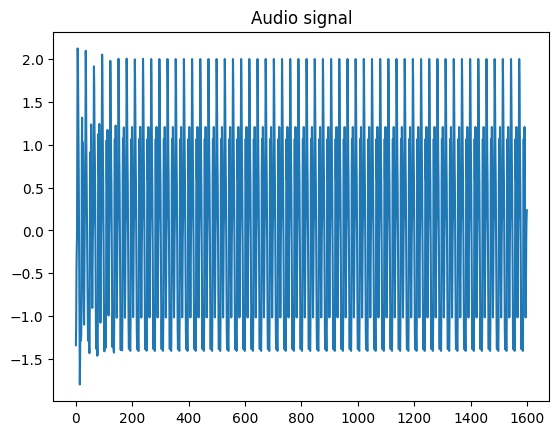

In [9]:
from matplotlib import pyplot as plt

plt.plot(audio)
plt.title("Audio signal");